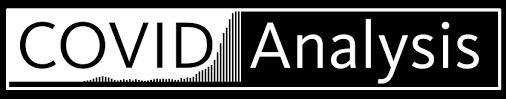

# COVID-19: current situation

- EDA including **the recent updates, recovering country analysis & sigmoid fitting convergence date estimation**.
- `plotly` visualization is heavy used

## Table of Contents


**[Load Data](#id_load)**<br/>
**[Worldwide trend](#id_ww)**<br/>
**[Country-wise growth](#id_country)**<br/>
**[Going into province](#id_province)**<br/>

**[Europe](#id_europe)**<br/>
**[Asia](#id_asia)**<br/>
**[Which country is recovering now?](#id_recover)**<br/>


In [ ]:
import gc
import os
from pathlib import Path
import random
import sys

from tqdm.notebook import tqdm 
#tqdm to print progress in a script I'm running in a Jupyter notebook. I can print all messages to the console via tqdm.write().
import numpy as np
import pandas as pd



import matplotlib.pyplot as plt
import seaborn as sns
from IPython.core.display import display, HTML



# --- plotly ---
from plotly import tools, subplots
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
import plotly.io as pio
pio.templates.default = "xgridoff"   #giving light grid background template for all the visualization

# --- models ---
from sklearn import preprocessing


- gc — Garbage Collector interface

This module provides an interface to the optional garbage collector. It provides the ability to disable the collector, tune the collection frequency, and set debugging options. It also provides access to unreachable objects that the collector found but cannot free. Since the collector supplements the reference counting already used in Python, you can disable the collector if you are sure your program does not create reference cycles. Automatic collection can be disabled by calling gc.disable(). To debug a leaking program call gc.set_debug(gc.DEBUG_LEAK). Notice that this includes gc.DEBUG_SAVEALL, causing garbage-collected objects to be saved in gc.garbage for inspection.

- IPython.core.display.DisplayObject

(Create an audio object.)

When this object is returned by an input cell or passed to the display function, it will result in Audio controls being displayed in the frontend (only works in the notebook).

- XGBoost Documentation

XGBoost is an optimized distributed gradient boosting library designed to be highly efficient, flexible and portable. It implements machine learning algorithms under the Gradient Boosting framework. XGBoost provides a parallel tree boosting (also known as GBDT, GBM) that solve many data science problems in a fast and accurate way. The same code runs on major distributed environment (Hadoop, SGE, MPI) and can solve problems beyond billions of examples.

- What is CatBoost?

CatBoost is a recently open-sourced machine learning algorithm from Yandex. It can easily integrate with deep learning frameworks like Google’s TensorFlow and Apple’s Core ML. It can work with diverse data types to help solve a wide range of problems that businesses face today. To top it up, it provides best-in-class accuracy.

It is especially powerful in two ways:

    It yields state-of-the-art results without extensive data training typically required by other machine learning methods, and
    Provides powerful out-of-the-box support for the more descriptive data formats that accompany many business problems.


<a id="id_load"></a>
# Load Data

Download latest data from Johns Hopkins University github repository: [https://github.com/CSSEGISandData/COVID-19](https://github.com/CSSEGISandData/COVID-19)

In [ ]:

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     filenames.sort()
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

In [ ]:
%%time
import requests

for filename in ['time_series_covid19_confirmed_global.csv',
                 'time_series_covid19_deaths_global.csv',
                 'time_series_covid19_recovered_global.csv',
                 'time_series_covid19_confirmed_US.csv',
                 'time_series_covid19_deaths_US.csv']:
    print(f'Downloading {filename}')

    url = f'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/{filename}'
#if check_update and False:
    myfile = requests.get(url)
    open(filename, 'wb').write(myfile.content)
    
    #importing the datasets
    

# 1 : ANALYSIS FOR GLOBAL CASES

In [ ]:
from datetime import datetime  #importing datetime to convert dates , String into datetime

def _convert_date_str(df):
    try:
        df.columns = list(df.columns[:4]) + [datetime.strptime(d, "%m/%d/%y").date().strftime("%Y-%m-%d") for d in df.columns[4:]]
    except:
        print('_convert_date_str failed with %y, try %Y')
        df.columns = list(df.columns[:4]) + [datetime.strptime(d, "%m/%d/%Y").date().strftime("%Y-%m-%d") for d in df.columns[4:]]

#converting function for all the date columns into datetime format with exception handeling 

confirmed_global_df = pd.read_csv('time_series_covid19_confirmed_global.csv')
_convert_date_str(confirmed_global_df)

deaths_global_df = pd.read_csv('time_series_covid19_deaths_global.csv')
_convert_date_str(deaths_global_df)

recovered_global_df = pd.read_csv('time_series_covid19_recovered_global.csv')
_convert_date_str(recovered_global_df)

In [ ]:
#confirmed dataframe
confirmed_global_df.head()

- Lat and Long_: Dot locations on the dashboard. All points (except for Australia) shown on the map are based on geographic centroids, and are not representative of a specific address, building or any location at a spatial scale finer than a province/state. Australian dots are located at the centroid of the largest city in each state.

In [ ]:
#death dataframe
deaths_global_df.head()

In [ ]:
#recovered dataframe
recovered_global_df.head()

In [ ]:
# Filter out problematic data points (The West Bank and Gaza had a negative value, cruise ships were associated with Canada, etc.)
removed_states = "Recovered|Grand Princess|Diamond Princess"
removed_countries = "US|The West Bank and Gaza"

#Renaming columns
confirmed_global_df.rename(columns={"Province/State": "Province_State", "Country/Region": "Country_Region"}, inplace=True)
deaths_global_df.rename(columns={"Province/State": "Province_State", "Country/Region": "Country_Region"}, inplace=True)
recovered_global_df.rename(columns={"Province/State": "Province_State", "Country/Region": "Country_Region"}, inplace=True)

#confirmed_global_df

In [ ]:
# Replacing NaN values with "nan"
# ~ Stands for Opposite 

confirmed_global_df = confirmed_global_df[~confirmed_global_df["Province_State"].replace(np.nan, "nan").str.match(removed_states)]
deaths_global_df    = deaths_global_df[~deaths_global_df["Province_State"].replace(np.nan, "nan").str.match(removed_states)]
recovered_global_df = recovered_global_df[~recovered_global_df["Province_State"].replace(np.nan, "nan").str.match(removed_states)]

confirmed_global_df = confirmed_global_df[~confirmed_global_df["Country_Region"].replace(np.nan, "nan").str.match(removed_countries)]
deaths_global_df    = deaths_global_df[~deaths_global_df["Country_Region"].replace(np.nan, "nan").str.match(removed_countries)]
recovered_global_df = recovered_global_df[~recovered_global_df["Country_Region"].replace(np.nan, "nan").str.match(removed_countries)]

In [ ]:
#df.melt ===>>> Unpivot a DataFrame from wide to long format, optionally leaving identifiers set.

confirmed_global_melt_df = confirmed_global_df.melt(
    id_vars=['Country_Region', 'Province_State', 'Lat', 'Long'], value_vars=confirmed_global_df.columns[4:], var_name='Date', value_name='ConfirmedCases')
deaths_global_melt_df = deaths_global_df.melt(
    id_vars=['Country_Region', 'Province_State', 'Lat', 'Long'], value_vars=confirmed_global_df.columns[4:], var_name='Date', value_name='Deaths')
recovered_global_melt_df = recovered_global_df.melt(
    id_vars=['Country_Region', 'Province_State', 'Lat', 'Long'], value_vars=confirmed_global_df.columns[4:], var_name='Date', value_name='Recovered')

In [ ]:
#confirmed_global_melt_df.head()

In [ ]:
#merging confirm,death and recovered dateframe

train = confirmed_global_melt_df.merge(deaths_global_melt_df, on=['Country_Region', 'Province_State', 'Lat', 'Long', 'Date'])
train = train.merge(recovered_global_melt_df, on=['Country_Region', 'Province_State', 'Lat', 'Long', 'Date'])

In [ ]:
train.head(10)

In [ ]:
Confirm=pd.DataFrame(train.groupby(['Date'])["ConfirmedCases"].agg(["sum"]))
Confirm.max()


In [ ]:
date= Confirm.index[Confirm["sum"] == 5031588 ]
date

   - 3582327 Confirm Cases Recorded Globally till Date 08,june,2020  

In [ ]:
train.head(10)

In [ ]:
cnf=pd.DataFrame(train.groupby(['Country_Region'])["ConfirmedCases"].agg("max"))
sorted_cnf=cnf.sort_values("ConfirmedCases",ascending=False).head(10)
sorted_cnf
# create a dataframe with Groupby 'Country_egion' with ConfirmCases's max values
#and Sorted it in Decsending order


In [ ]:
country=list(sorted_cnf.index[:10])
country
#we can take it as list but that will not be compatible with Run time Data

In [ ]:
colors=["r","r","r","r","r","orange","orange","orange","yellow","yellow"]
plt.figure(figsize=(12,8))
sns.barplot(x=country,y="ConfirmedCases",data=sorted_cnf,palette=colors)
plt.title("Top 10 Countries with Maximum Confirm Cases (which have Most Confirm Cases)",fontsize=14)
plt.xlabel("Countries")
plt.ylabel("Confirm Cases")
plt.show()

- Russia,Brazil,United_Kingdom,Spain,India are Top 5 Countries with Most Confirm Cases
- INDIA is now in  5th Country with Most Confirm Case

In [ ]:
dth=pd.DataFrame(train.groupby(['Country_Region'])["Deaths"].agg("max"))
dth
sorted_dth=dth.sort_values("Deaths",ascending=False).head(10)
sorted_dth
country=list(sorted_dth.index[:10])
country

colors=["k","k","k","k","k","r","r","r","r","orange"]
plt.figure(figsize=(12,8))
sns.barplot(x=country,y="Deaths",data=sorted_dth,palette=colors)
plt.title("Top 10 Countreis with Maximum Deaths (which have most confirm cases)",fontsize=14)
plt.xlabel("Countries")
plt.ylabel("Deaths")
plt.show()




   - United_Kingdom,Italy,France,Spain,Brazil are Top 5 Countries with Most Death Cases
   - India is in 10th Country with Most Confirm Case



In [ ]:
rcvd=pd.DataFrame(train.groupby(['Country_Region'])["Recovered"].agg("max"))
rcvd
sorted_rcvd=rcvd.sort_values("Recovered",ascending=False).head(10)
sorted_rcvd
country=list(sorted_rcvd.index[:10])
country

colors=["g","g","g","g","skyblue","skyblue","skyblue","orange","orange","orange"]
plt.figure(figsize=(12,8))
sns.barplot(x=country,y="Recovered",data=sorted_rcvd,palette=colors)
plt.title("Top 10 Countreis with Maximum Recoveries(which have most confirm cases)",fontsize=14)
plt.xlabel("Countries")
plt.ylabel("Recoveries")
plt.show()



- Germany,Russia,Italy,Brazil are Top 4 Countries with Most Recovery
- INDIA is in 8th Country with Most Good Recovery Rate 



In [ ]:
#Top Countries with Most Confirm Cases
sorted_cnf

In [ ]:
#Top Countries with Most Death Cases
sorted_dth

In [ ]:
#Top Countries with Most Recovery Cases
sorted_rcvd

In [ ]:
x=sorted_cnf.merge(sorted_rcvd, on='Country_Region')
df_rc=pd.DataFrame(x)
#df_rc
country_rc=list(df_rc.index)
country_rc
df_rc["Recovery_Percentage"]=(df_rc.Recovered/df_rc.ConfirmedCases)*100
df_rc


In [ ]:
colors=["#e31212","#f0ac0e","#52ff80","#91fa2f","#f77625","#008223","#1df557","#07b836","#f0e91d"]
sns.barplot(x=country_rc,y="Recovery_Percentage",data=df_rc,palette=colors)
plt.title("Recovery_Percentage Of Most Confirm Cases Country",fontsize=14)
plt.xlabel("Countries")
plt.ylabel("Recovery")
plt.show()


- Recovery pecentage is quite high of Germany,Iran and Italy [70% +]

In [ ]:
y=sorted_cnf.merge(sorted_dth, on='Country_Region')
df_dt=pd.DataFrame(y)
df_dt
country_dt=list(df_dt.index)
#country_dt
df_dt["Death_Percentage"]=(df_dt.Deaths/df_dt.ConfirmedCases)*100
df_dt

In [ ]:
colors=["r","k","darkgray","k","k","r","r"]
sns.barplot(x=country_dt,y="Death_Percentage",data=df_dt,palette=colors)
plt.title("Death_Percentage Of Most Confirm Cases Countries",fontsize=14)
plt.xlabel("Country")
plt.ylabel("Death_Pct")
plt.show()

- Death Percentage of France ,Italy,United Kingdom is very high [14% +]

# 2: ANALYZE US

In [ ]:
# --- US ---
#importing data
confirmed_us_df = pd.read_csv('time_series_covid19_confirmed_US.csv')
deaths_us_df = pd.read_csv('time_series_covid19_deaths_US.csv')
confirmed_us_df.head(3)
deaths_us_df.head(3)

In [ ]:

#permanently_dropping _columns _which_we_will_not_use

confirmed_us_df.drop(['UID', 'iso2', 'iso3', 'code3', 'FIPS', 'Admin2', 'Combined_Key'], inplace=True, axis=1)
deaths_us_df.drop(['UID', 'iso2', 'iso3', 'code3', 'FIPS', 'Admin2', 'Combined_Key', 'Population'], inplace=True, axis=1)



In [ ]:
confirmed_us_df.head(3)
deaths_us_df.head(3)

In [ ]:

#renaming_columns_as_previous

confirmed_us_df.rename({'Long_': 'Long'}, axis=1, inplace=True)
deaths_us_df.rename({'Long_': 'Long'}, axis=1, inplace=True)

#converting_datetime_in_string

_convert_date_str(confirmed_us_df)
_convert_date_str(deaths_us_df)

# clean
confirmed_us_df = confirmed_us_df[~confirmed_us_df.Province_State.str.match("Diamond Princess|Grand Princess|Recovered|Northern Mariana Islands|American Samoa")]
deaths_us_df = deaths_us_df[~deaths_us_df.Province_State.str.match("Diamond Princess|Grand Princess|Recovered|Northern Mariana Islands|American Samoa")]



In [ ]:
# --- Aggregate by province state ---

#confirmed_us_df.groupby(['Country_Region', 'Province_State'])  & resetting_index
confirmed_us_df = confirmed_us_df.groupby(['Country_Region', 'Province_State']).sum().reset_index()
deaths_us_df = deaths_us_df.groupby(['Country_Region', 'Province_State']).sum().reset_index()

confirmed_us_df.head(2)

In [ ]:
# remove lat,long columns

confirmed_us_df.drop(['Lat', 'Long'], inplace=True, axis=1)
deaths_us_df.drop(['Lat', 'Long'], inplace=True, axis=1)

In [ ]:


#Unpivot a DataFrame from wide to long format, optionally leaving identifiers set.

confirmed_us_melt_df = confirmed_us_df.melt(
    id_vars=['Country_Region', 'Province_State'], value_vars=confirmed_us_df.columns[2:], var_name='Date', value_name='ConfirmedCases')
deaths_us_melt_df = deaths_us_df.melt(
    id_vars=['Country_Region', 'Province_State'], value_vars=deaths_us_df.columns[2:], var_name='Date', value_name='Deaths')

confirmed_us_melt_df
deaths_us_melt_df

In [ ]:
#merging_both_dataframe
train_us = confirmed_us_melt_df.merge(deaths_us_melt_df, on=['Country_Region', 'Province_State', 'Date'])
train_us.head()

#### The Data_set of US MERGING WITH GLOBLE DATA

In [ ]:
train = pd.concat([train, train_us], axis=0, sort=False)

train_us.rename({'Country_Region': 'country', 'Province_State': 'province', 'Date': 'date', 'ConfirmedCases': 'confirmed', 'Deaths': 'fatalities'}, axis=1, inplace=True)
train_us['country_province'] = train_us['country'].fillna('') + '/' + train_us['province'].fillna('')

In [ ]:
train

In [ ]:
%%time
datadir = Path('/kaggle/input/covid19-global-forecasting-week-4')

# Read in the data CSV files
#train = pd.read_csv(datadir/'train.csv')
#test = pd.read_csv(datadir/'test.csv')
#submission = pd.read_csv(datadir/'submission.csv')


In [ ]:
train

In [ ]:
#test

In [ ]:
#submission

In [ ]:
#Renaming Colums

train.rename({'Country_Region': 'country', 'Province_State': 'province', 'Id': 'id', 'Date': 'date', 'ConfirmedCases': 'confirmed', 'Deaths': 'fatalities', 'Recovered': 'recovered'}, axis=1, inplace=True)

#created new column with the help of "country" and "province" and fill NaN value to (" ")

train['country_province'] = train['country'].fillna('') + '/' + train['province'].fillna('')

# test.rename({'Country_Region': 'country', 'Province_State': 'province', 'Id': 'id', 'Date': 'date', 'ConfirmedCases': 'confirmed', 'Fatalities': 'fatalities'}, axis=1, inplace=True)
# test['country_province'] = test['country'].fillna('') + '/' + test['province'].fillna('')

In [ ]:
train.head()

In [ ]:
cnf2=pd.DataFrame(train.groupby(['country'])["confirmed"].agg("max"))
sorted_cnf2=cnf2.sort_values('confirmed',ascending=False).head(5)
country=list(sorted_cnf2.index[:5])
country

In [ ]:
colors=["#fa0707","#db4116","#db5b16","#db7916","#db9a16"]
#plt.figure(figsize=(12,8))
sns.barplot(x=country,y="confirmed",data=sorted_cnf2,palette=colors)
plt.title(r"Top 10 Countries with Maximum Confirm Cases(including US)",fontsize=14 )
plt.xlabel("Countries")
plt.ylabel("Confirm Cases")
plt.show()

###### here we can see the Confirm Cases in US is Less  than Brazil & Russia

In [ ]:
dth2=pd.DataFrame(train.groupby(['country'])["fatalities"].agg("max"))
dth2
sorted_dth2=dth2.sort_values("fatalities",ascending=False).head(3)
sorted_dth2
country=list(sorted_dth2.index[:3])
country

colors=["k","#33322f","#9e9c98"]
#plt.figure(figsize=(12,8))
sns.barplot(x=country,y="fatalities",data=sorted_dth2,palette=colors)
plt.title("Top 10 Countreis with Maximum Deaths (Including US)",fontsize=14)
plt.xlabel("Countries")
plt.ylabel("Deaths")
plt.show()

###### This is a little bit Positive sign For US that The US's Death_Rate is lesser than UK,Brazil  and Italy .

In [ ]:
rcvd2=pd.DataFrame(train.groupby(['country'])["recovered"].agg("max"))
rcvd2
sorted_rcvd2=rcvd2.sort_values("recovered",ascending=False).head(20)
sorted_rcvd2
country=list(sorted_rcvd2.index[:20])
country


plt.figure(figsize=(18,12))
sns.barplot(x=country,y="recovered",data=sorted_rcvd2)
plt.title("Top 10 Countreis with Maximum Recoveries(including US)",fontsize=14)
plt.xlabel("Countries")
plt.ylabel("Recoveries")
plt.show()

###### Little bit shocking but US is not even in Top 20 In top Recovered Countries Where Brazil is in Top

<a id="id_ww"></a>
# Worldwide trend

In [ ]:
ww_df = train.groupby('date')[['confirmed', 'fatalities']].sum().reset_index()
ww_df.head()

In [ ]:
#ww_df = train.groupby('date')[['confirmed', 'fatalities']].sum().reset_index()
ww_df['new_case'] = ww_df['confirmed'] - ww_df['confirmed'].shift(1)

"""Shift index by desired number of periods with an optional time `freq`.

When `freq` is not passed, shift the index without realigning the data.
If `freq` is passed (in this case, the index must be date or datetime,
or it will raise a `NotImplementedError`), the index will be
increased using the periods and the `freq`."""

ww_df.head()

#here new_case column will be increase as per date column

In [ ]:
#unpivoting the dataframe
ww_melt_df = pd.melt(ww_df, id_vars=['date'], value_vars=['confirmed', 'fatalities', 'new_case'])
ww_melt_df

When we see the confirmed cases in world wide, it just look like exponential growth curve. The number is increasing very rapidly especially recently. **the number almost doubled in last 1 week**...

<span style="color:red"><b>Confirmed cases reached 1M people, and 52K people already died on April 2</b></span>.<br/>
<span style="color:red"><b>Confirmed cases reached 3.3M people, and 238K people already died on May 1</b></span>.

<span style="color:red"><b>Confirmed cases reached 7.2M people, and 409K people already died on june 8 </b></span>.


In [ ]:
fig = px.line(ww_melt_df, x="date", y="value", color='variable', 
              title="Worldwide Confirmed/Death Cases Over Time")
fig.show()

Moreover, when we check the growth in log-scale below figure, we can see that the speed of confirmed cases growth rate **slightly increases** when compared with the beginning of March and end of March.<br/>
In spite of the Lockdown policy in Europe or US, the number is still increasing rapidly.

In [ ]:
fig = px.line(ww_melt_df, x="date", y="value", color='variable',
              title="Worldwide Confirmed/Death Cases Over Time (Log scale)",
             log_y=True)
#log_y: boolean (default `False`)
"""If `True`, the y-axis is log-scaled in cartesian coordinates.(comment)"""
fig.show()

It looks like `fatalities` curve is just shifted the `confirmed` curve to below in log-scale, which means mortality rate is almost constant.

Is it true? Let's see mortality rate in detail.<br/>
We see that mortality rate is kept almost 3%, however it is slightly **increasing gradually to go over 7%** at the end of April.

Why? I will show you later that Europe & US has more seriously infected by Coronavirus recently, and mortality rate is high in these regions.<br/>
It might be because when too many people get coronavirus, the country cannot provide enough medical treatment.

In [ ]:
ww_df['mortality'] = ww_df['fatalities'] / ww_df['confirmed']
#creating New_column with the help of "fatalities & confirmed"
fig = px.line(ww_df, x="date", y="mortality", 
              title="Worldwide Mortality Rate Over Time")
fig.show()


- As we can see here that the Mortality rate was going upwards till 26 April but there is a decreasing in the Mortality rate after that. 

<a id="id_country"></a>
# Country-wise growth

In [ ]:
#creating New data frame with the help of previous one


In [ ]:
country_df = train.groupby(['date', 'country'])[['confirmed', 'fatalities']].sum().reset_index()
country_df.tail()

What kind of country is in the dataset? How's the distribution of number of confirmed cases by country?

In [ ]:
countries = country_df['country'].unique()
print(f'{len(countries)} countries are in dataset:\n{countries}')

- there are 177 Countries in this Report

In [ ]:
target_date = country_df['date'].max()
print('Date: ', target_date)



In [ ]:
for i in [1, 10, 100, 1000, 10000]:
    n_countries = len(country_df.query('(date == @target_date) & confirmed > @i'))
    print(f'{n_countries} countries have more than {i} confirmed cases')

- np.log10() ====>>> function helps user to calculate Base-10 logarithm of x where x belongs to all the input array elements. 

In [ ]:
ax = sns.distplot(np.log10(country_df.query('date == "2020-06-08"')['confirmed'] + 1))
ax.set_xlim([0, 6])
ax.set_xticks(np.arange(7))
_ = ax.set_xticklabels(['0', '10', '100', '1k', '10k', '100k'])

It is difficult to see all countries so let's check top countries.

In [ ]:
top_country_df = country_df.query('(date == @target_date) & (confirmed > 1000)').sort_values('confirmed', ascending=False)
top_country_melt_df = pd.melt(top_country_df, id_vars='country', value_vars=['confirmed', 'fatalities'])
top_country_melt_df

Now **US, Brazil and Russia and Even India**  has more confirmed cases than China, and we can see many Europe countries in the top.



In [ ]:
fig = px.bar(top_country_melt_df.iloc[::-1],
             x='value', y='country', color='variable', barmode='group',
             title=f'Confirmed Cases/Deaths on {target_date}', text='value', height=1500, orientation='h')
fig.show()

Let's check these major country's growth by date.

As we can see, Coronavirus hit **China** at first but its trend is slowing down in March which is good news.<br/>
Bad news is 2nd wave comes to **Europe (Italy, Spain, Germany, France, UK)** at March.<br/>
sadly 3rd wave now comes to **US, whose growth rate is much much faster than China, or even Europe**. Its main spread starts from middle of March and its speed is faster than Italy. Now US seems to be in the most serious situation in terms of both total number and spread speed.<br/>

But more sadly 3rd wave now comes to **Brazil and India, whose growth rate is much much faster than China**.


In [ ]:
top30_countries = top_country_df.sort_values('confirmed', ascending=False).iloc[:30]['country'].unique()
top30_countries_df = country_df[country_df['country'].isin(top30_countries)]
fig = px.line(top30_countries_df,
              x='date', y='confirmed', color='country',
              title=f'Confirmed Cases for top 30 country as of {target_date}')
fig.show()

In [ ]:
top30_countries = top_country_df.sort_values('fatalities', ascending=False).iloc[:30]['country'].unique()
top30_countries_df = country_df[country_df['country'].isin(top30_countries)]
fig = px.line(top30_countries_df,
              x='date', y='fatalities', color='country',
              title=f'Fatalities for top 30 country as of {target_date}')
fig.show()

- In terms of number of fatalities, Brazil & US are serious situation now

##### Now let's see mortality rate by country

In [ ]:
top_country_df = country_df.query('(date == @target_date) & (confirmed > 100)')
top_country_df['mortality_rate'] = top_country_df['fatalities'] / top_country_df['confirmed']
top_country_df = top_country_df.sort_values('mortality_rate', ascending=False)

In [ ]:
fig = px.bar(top_country_df[:30].iloc[::-1],
             x='mortality_rate', y='country',
             title=f'Mortality rate HIGH: top 30 countries on {target_date}', text='mortality_rate', height=800, orientation='h')
fig.show()

Belgium, France and Italy is the most serious situation respectively , whose mortality rate is over 14% as of 2020/6/08.

We can also find countries from all over the world when we see top mortality rate countries.<br/>


Spain, Netherlands, India, and UK . It shows this coronavirus is really world wide pandemic.


###### How about the countries whose mortality rate is low?

By investigating the difference between above & below countries, we might be able to figure out what is the cause which leads death.<br/>
Be careful that there may be a case that these country's mortality rate is low due to these country does not report/measure fatality cases properly.

In [ ]:
fig = px.bar(top_country_df[-30:],
             x='mortality_rate', y='country',
             title=f'Mortality rate LOW: top 30 countries on {target_date}', text='mortality_rate', height=800, orientation='h')
fig.show()

Let's see number of confirmed cases on map. Again we can see Europe, US, MiddleEast (Turkey, Iran) and Asia (China, Korea) are Not here.

In [ ]:
all_country_df = country_df.query('date == @target_date')
all_country_df['confirmed_log1p'] = np.log10(all_country_df['confirmed'] + 1)
all_country_df['fatalities_log1p'] = np.log10(all_country_df['fatalities'] + 1)
all_country_df['mortality_rate'] = all_country_df['fatalities'] / all_country_df['confirmed']

In [ ]:
fig = px.choropleth(all_country_df, locations="country", 
                    locationmode='country names', color="confirmed_log1p", 
                    hover_name="country", hover_data=["confirmed", 'fatalities', 'mortality_rate'],
                    range_color=[all_country_df['confirmed_log1p'].min(), all_country_df['confirmed_log1p'].max()], 
                    color_continuous_scale="peach", 
                    title='Countries with Confirmed Cases')

# I'd like to update colorbar to show raw values, but this does not work somehow...
# Please let me know if you know how to do this!!
trace1 = list(fig.select_traces())[0]
trace1.colorbar = go.choropleth.ColorBar(
    tickvals=[0, 1, 2, 3, 4, 5],
    ticktext=['1', '10', '100', '1000','10000', '10000'])
fig.show()

When we see Confirm cases rate on map, we see **US,Brazil & Russia is high** . Also we notice MiddleEast (Iran, Iraq) is high.

When we see tropical area, I wonder why Phillipines and Indonesia are high while other countries (Malaysia, Thai, Vietnam, as well as Australia) are low.

For Asian region, Korea's mortality rate is lower than China or India, I guess this is due to the fact that number of inspection is quite many in Korea.



In [ ]:

fig = px.choropleth(all_country_df, locations="country", 
                    locationmode='country names', color="fatalities_log1p", 
                    hover_name="country", range_color=[0, 4],
                    #hover_data=['confirmed', 'fatalities', 'mortality_rate'],
                    color_continuous_scale="peach", 
                    title='Countries with fatalities')
fig.show()

Here we can see **US, Brazil, France,Spain,Iran** with most numer of fatalities

In [ ]:
fig = px.choropleth(all_country_df, locations="country", 
                    locationmode='country names', color="mortality_rate", 
                    hover_name="country", range_color=[0, 0.12], 
                    color_continuous_scale="peach", 
                    title='Countries with mortality rate')
fig.show()

## Daily NEW confirmed cases trend

How about **DAILY new cases** trend?<br/>
We find from below figure:
 - China has finished its peak at Feb 14, new confirmed cases are surpressed now.
 - Europe&US spread starts on mid of March, after China slows down.
 - I feel effect of lock down policy in Europe (Italy, Spain, Germany, France) now comes on the figure,
   the number of new cases are not so increasing rapidly at the end of May.
 - Current US new confirmed cases are the worst speed, recording worst speed at more than 30k people/day at peak. 

- Daily new confirmed cases start to decrease from April 26 or April 10, I hope this trend will continue.



In [ ]:
country_df['prev_confirmed'] = country_df.groupby('country')['confirmed'].shift(1)
country_df['new_case'] = country_df['confirmed'] - country_df['prev_confirmed']
country_df['new_case'].fillna(0, inplace=True)
top30_country_df = country_df[country_df['country'].isin(top30_countries)]

fig = px.line(top30_country_df,
              x='date', y='new_case', color='country',
              title=f'DAILY NEW Confirmed cases world wide')
fig.show()

- **US, Brazil and INDIA** are top 3 countries now with daily confirm cases

## Geographical animation: spready by date

You can see animation how confirmed cases spread over time, you can see trend moving to China -> Europe -> US.

In [ ]:
country_df['date'] = country_df['date'].apply(str)
country_df['confirmed_log1p'] = np.log1p(country_df['confirmed'])
country_df['fatalities_log1p'] = np.log1p(country_df['fatalities'])

fig = px.scatter_geo(country_df, locations="country", locationmode='country names', 
                     color="confirmed", size='confirmed', hover_name="country", 
                     hover_data=['confirmed', 'fatalities'],
                     range_color= [0, country_df['confirmed'].max()], 
                     projection="natural earth", animation_frame="date", 
                     title='COVID-19: Confirmed cases spread Over Time', color_continuous_scale="portland")
# fig.update(layout_coloraxis_showscale=False)
fig.show()

You can see animation how confirmed cases spread over time, you can see trend moving to China -> Europe -> US. But Europe is worse than US for number of fatalities now.

In [ ]:
fig = px.scatter_geo(country_df, locations="country", locationmode='country names', 
                     color="fatalities", size='fatalities', hover_name="country", 
                     hover_data=['confirmed', 'fatalities'],
                     range_color= [0, country_df['fatalities'].max()], 
                     projection="natural earth", animation_frame="date", 
                     title='COVID-19: Fatalities growth Over Time', color_continuous_scale="portland")
fig.show()

New cases trend: it looks like China is almost converged now.

In [ ]:
country_df.loc[country_df['new_case'] < 0, 'new_case'] = 0.
fig = px.scatter_geo(country_df, locations="country", locationmode='country names', 
                     color="new_case", size='new_case', hover_name="country", 
                     hover_data=['confirmed', 'fatalities'],
                     range_color= [0, country_df['new_case'].max()], 
                     projection="natural earth", animation_frame="date", 
                     title='COVID-19: Daily NEW cases over Time', color_continuous_scale="portland")
fig.show()

<a id="id_europe"></a>
# Europe

In [ ]:
# Ref: https://www.kaggle.com/abhinand05/covid-19-digging-a-bit-deeper
europe_country_list =list([
    'Austria','Belgium','Bulgaria','Croatia','Cyprus','Czechia','Denmark','Estonia','Finland','France','Germany','Greece','Hungary','Ireland',
    'Italy', 'Latvia','Luxembourg','Lithuania','Malta','Norway','Netherlands','Poland','Portugal','Romania','Slovakia','Slovenia',
    'Spain', 'Sweden', 'United Kingdom', 'Iceland', 'Russia', 'Switzerland', 'Serbia', 'Ukraine', 'Belarus',
    'Albania', 'Bosnia and Herzegovina', 'Kosovo', 'Moldova', 'Montenegro', 'North Macedonia'])

country_df['date'] = pd.to_datetime(country_df['date'])
train_europe = country_df[country_df['country'].isin(europe_country_list)]
#train_europe['date_str'] = pd.to_datetime(train_europe['date'])
train_europe_latest = train_europe.query('date == @target_date')

When we look into the Europe, its Northern & Eastern areas are relatively better situation compared to Eastern & Southern areas.

In [ ]:
fig = px.choropleth(train_europe_latest, locations="country", 
                    locationmode='country names', color="confirmed", 
                    hover_name="country", range_color=[1, train_europe_latest['confirmed'].max()], 
                    color_continuous_scale='portland', 
                    title=f'European Countries with Confirmed Cases as of {target_date}', scope='europe', height=800)
fig.show()

Especially **Russia and UK** are in more serious situation.

Number of confirmed cases rapidly increasing in **Russia now (as of May 1)**, **Russia** is now potentially very dangerous situation.

In [ ]:
train_europe_march = train_europe.query('date >= "2020-03-01"')
fig = px.line(train_europe_march,
              x='date', y='confirmed', color='country',
              title=f'Confirmed cases by country in Europe, as of {target_date}')
fig.show()

In [ ]:
fig = px.line(train_europe_march,
              x='date', y='fatalities', color='country',
              title=f'Fatalities by country in Europe, as of {target_date}')
fig.show()

When we check daily new cases in Europe, we notice:

 - **UK and Russia** daily growth are more than Italy now, These countries are potentially more dangerous now.


In [ ]:
train_europe_march['prev_confirmed'] = train_europe_march.groupby('country')['confirmed'].shift(1)
train_europe_march['new_case'] = train_europe_march['confirmed'] - train_europe_march['prev_confirmed']
fig = px.line(train_europe_march,
              x='date', y='new_case', color='country',
              title=f'DAILY NEW Confirmed cases by country in Europe')
fig.show()

Daily new Cases Increasing Rate is increasing unexpexctedly in **Russia and UK** 

<a id="id_asia"></a>
# Asia

In Asia, India & Iran have many confirmed cases, followed by South Korea & Turkey. 

In [ ]:
country_latest = country_df.query('date == @target_date')

fig = px.choropleth(country_latest, locations="country", 
                    locationmode='country names', color="confirmed", 
                    hover_name="country", range_color=[1, 50000], 
                    color_continuous_scale='portland', 
                    title=f'Asian Countries with Confirmed Cases as of {target_date}', scope='asia', height=800)
fig.show()

In [ ]:
top_asian_country_df = country_df[country_df['country'].isin(['China', 'Indonesia', 'Iran', 'Japan', 'Korea, South', 'Malaysia', 'Philippines','India'])]

fig = px.line(top_asian_country_df,
              x='date', y='new_case', color='country',
              title=f'DAILY NEW Confirmed cases world wide')
fig.show()

The coronavirus hit Asia in early phase, how is the situation now?
China & Korea is already in decreasing phase.

Unlike China or Korea, daily new confirmed cases were kept increasing on  April, especially in **India and Iran**. 

<a id="id_recover"></a>
# Which country is recovering now?

We saw that Coronavirus now hits Asia , Europe & US, in serious situation. How does it converge?

We can refer other country where confirmed cases is already decreasing.
Here I defined `new_case_peak_to_now_ratio`, as a ratio of current new case and the max new case for each country.
If new confirmed case is biggest now, its ratio is 1.
Its ratio is expected to be low value for the countries where the peak has already finished.  

In [ ]:
max_confirmed = country_df.groupby('country')['new_case'].max().reset_index()
country_latest = pd.merge(country_latest, max_confirmed.rename({'new_case': 'max_new_case'}, axis=1))
country_latest['new_case_peak_to_now_ratio'] = country_latest['new_case'] / country_latest['max_new_case']

In [ ]:
recovering_country = country_latest.query('new_case_peak_to_now_ratio < 0.5')
major_recovering_country = recovering_country.query('confirmed > 100')
major_recovering_country.sort_values(by=['confirmed'], inplace=True)
major_recovering_country


In [ ]:
fig = px.bar(major_recovering_country.sort_values('new_case_peak_to_now_ratio', ascending=False),
             x='new_case_peak_to_now_ratio', y='country',
             title=f'Mortality rate LOW: top 30 countries on {target_date}', text='new_case_peak_to_now_ratio', height=1000, orientation='h')
fig.show()

Let's see by map **China , Austrailia, France** currently decreasing in morality rate countries....so we can say these countries are recovering 

Let's see a recovering countries.

## China

When we check each state stats, we can see Hubei, the starting place, is extremely large number of confirmed cases.<br/>
Other states records actually few confirmed cases compared to Hubei.

In [ ]:
china_df = train.query('country == "China"')
china_df['prev_confirmed'] = china_df.groupby('province')['confirmed'].shift(1)
china_df['new_case'] = china_df['confirmed'] - china_df['prev_confirmed']
china_df.loc[china_df['new_case'] < 0, 'new_case'] = 0.

In [ ]:
fig = px.line(china_df,
              x='date', y='new_case', color='province',
              title=f'DAILY NEW Confirmed cases in China by province')
fig.show()

## The situation of Hubei now?

Hubei record its new case peak on Feb 14. And finally, new case was not found on March 19.

To become no new case found, it took **about 2month after confirmed cases occured**, and **1 month after the peak has reached.** <br/>
This term will be the reference for other country to how long we must lock-down the city.

The lockdown of Hubei's capital Wuhan will be lifted on April 8, a milestone in China's war against the epidemic.